In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2 as cv
import os
from tensorflow import keras
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

2024-07-25 07:59:27.053773: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 07:59:27.053908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 07:59:27.206073: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_dir = r'/kaggle/input/animals-detection-images-dataset/train/'
test_dir = r'/kaggle/input/animals-detection-images-dataset/test/'

labels = ['Butterfly',
       'Caterpillar','Chicken', 'Crab',
       'Deer', 'Duck', 'Eagle','Fish',
       'Frog', 'Giraffe','Goose', 'Horse',
       'Jellyfish', 'Ladybug', 'Lion',
       'Lizard','Monkey','Owl', 'Parrot',
       'Penguin',
       'Shark','Snail', 'Snake',
       'Sparrow', 'Spider','Squirrel',
       'Tiger', 'Tortoise','Whale','Leopard']

label_len = len(labels)
print(label_len)

30


In [4]:
# Variables pour les données d'entraînement
X = []
Y = []

# Chargement des données
for label in labels:
    folderpath = os.path.join(train_dir, label)
    
    for file in os.listdir(folderpath):
        img_path = os.path.join(folderpath, file)
        img = cv.imread(img_path)
        
        if img is not None:
            img = cv.resize(img, (224, 224))
            X.append(np.array(img))
            Y.append(labels.index(label))

# Conversion des listes en tableaux NumPy
X = np.array(X)
Y = np.array(Y)

In [5]:
print("Dimensions des données d'entraînement:")
print("X shape:", X.shape)
print("Y shape:", Y.shape)

Dimensions des données d'entraînement:
X shape: (15342, 224, 224, 3)
Y shape: (15342,)


In [6]:
# Variables pour les données de validation
X_valid = []
Y_valid = []
X_valid_path = []

# Chargement des données
for label in labels:
    folderpath = os.path.join(test_dir, label)
    
    for file in os.listdir(folderpath):
        img_path = os.path.join(folderpath, file)
        img = cv.imread(img_path)
        
        if img is not None:
            img = cv.resize(img, (224, 224))
            X_valid.append(np.array(img))
            X_valid_path.append(img_path)
            Y_valid.append(labels.index(label))
            
X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

In [7]:
print("\nDimensions des données de validation:")
print("X_valid shape:", X_valid.shape)
print("Y_valid shape:", Y_valid.shape)


Dimensions des données de validation:
X_valid shape: (3979, 224, 224, 3)
Y_valid shape: (3979,)


In [8]:
total_images = X.shape[0] + X_valid.shape[0]
print("Nombre total d'images:", total_images)

Nombre total d'images: 19321


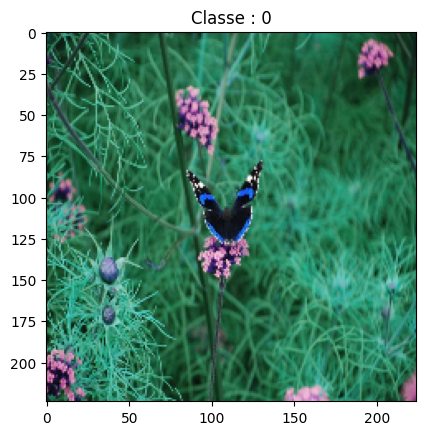

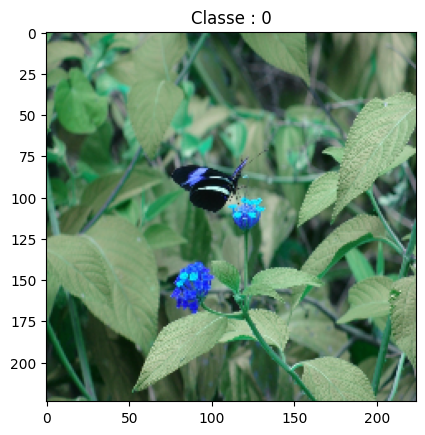

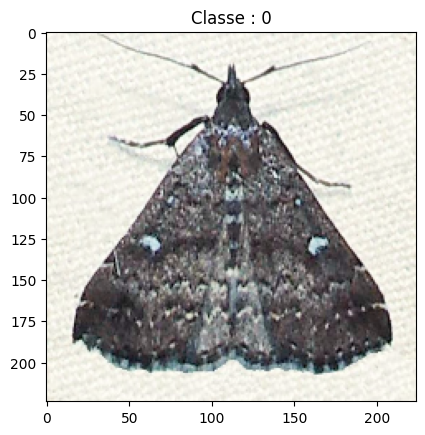

In [9]:
for i in range(3):
    plt.imshow(X[i])
    plt.title(f"Classe : {Y[i]}")
    plt.show()

In [10]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [11]:
base_model.trainable = False

In [12]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(labels), activation='softmax')(x)

In [13]:
model = Model(inputs=base_model.input, outputs=predictions)

In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# Conversion des labels en catégories one-hot
Y_one_hot = to_categorical(Y)
Y_valid_one_hot = to_categorical(Y_valid)

In [16]:
history = model.fit(X, Y_one_hot, epochs=20, validation_data=(X_valid, Y_valid_one_hot))


Epoch 1/20


I0000 00:00:1721894792.783745     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


480/480 [==============================] - 44s 76ms/step - loss: 0.7518 - accuracy: 0.7784 - val_loss: 0.4170 - val_accuracy: 0.8691
Epoch 2/20
480/480 [==============================] - 33s 68ms/step - loss: 0.4242 - accuracy: 0.8636 - val_loss: 0.3959 - val_accuracy: 0.8877
Epoch 3/20
480/480 [==============================] - 33s 68ms/step - loss: 0.2954 - accuracy: 0.8984 - val_loss: 0.4544 - val_accuracy: 0.8851
Epoch 4/20
480/480 [==============================] - 33s 68ms/step - loss: 0.2298 - accuracy: 0.9198 - val_loss: 0.4805 - val_accuracy: 0.8851
Epoch 5/20
480/480 [==============================] - 33s 68ms/step - loss: 0.1779 - accuracy: 0.9358 - val_loss: 0.5294 - val_accuracy: 0.8834
Epoch 6/20
480/480 [==============================] - 32s 66ms/step - loss: 0.1626 - accuracy: 0.9389 - val_loss: 0.6460 - val_accuracy: 0.8653
Epoch 7/20
480/480 [==============================] - 32s 66ms/step - loss: 0.1373 - accuracy: 0.9481 - val_loss: 0.5808 - val_accuracy: 0.8854
Epo

In [17]:
Y_pred = model.predict(X_valid)
Y_pred_classes = np.argmax(Y_pred, axis=1) 

125/125 [==============================] - 7s 49ms/step


In [18]:
conf_matrix = confusion_matrix(Y_valid, Y_pred_classes)
acc_score = accuracy_score(Y_valid, Y_pred_classes)
print("Score de précision:", acc_score)

Score de précision: 0.8743402865041467


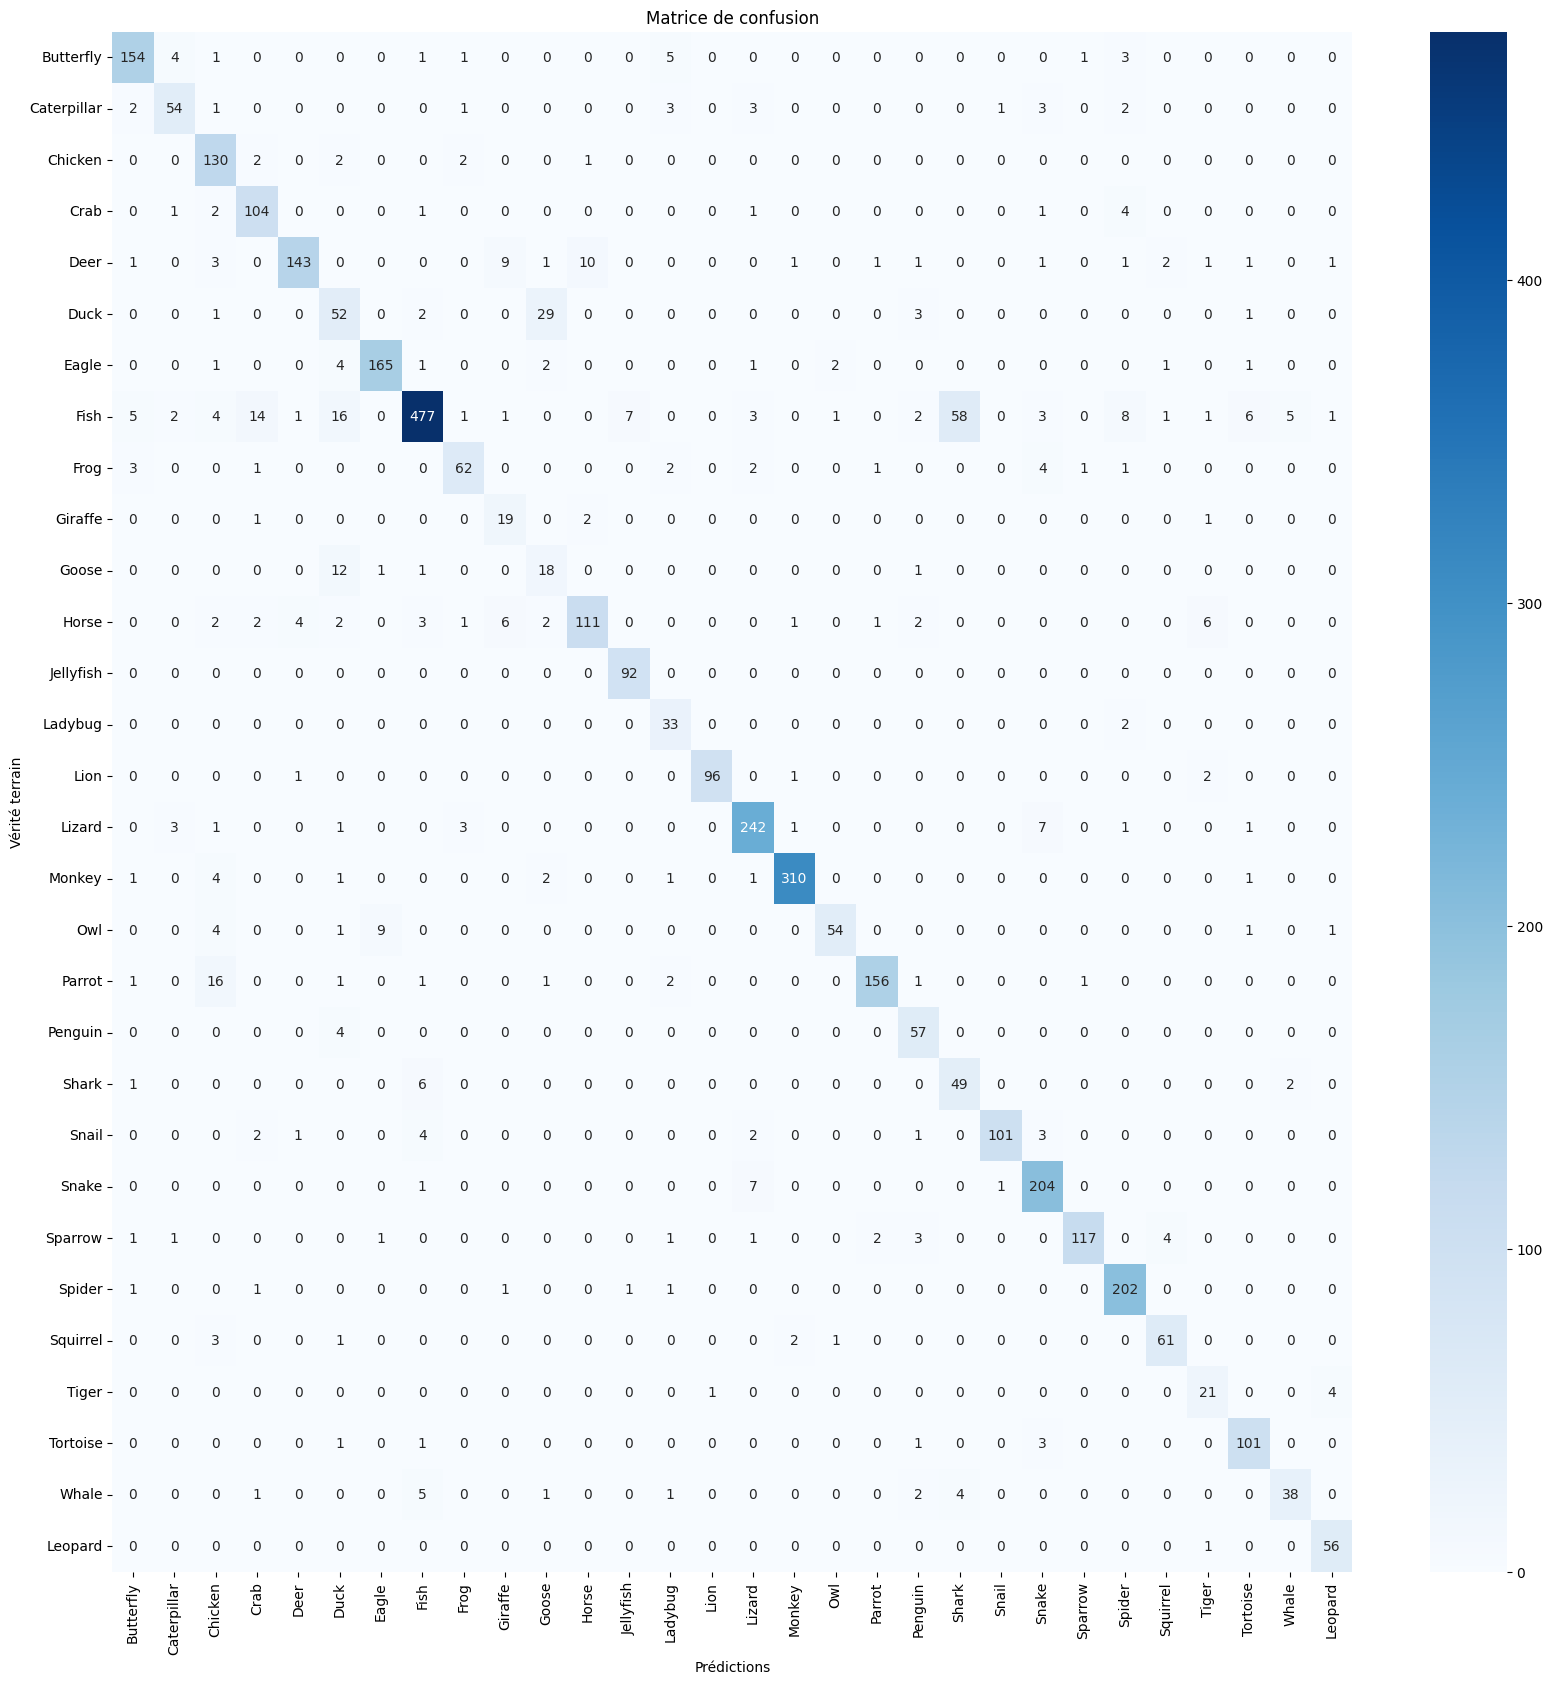

In [19]:
plt.figure(figsize=(20,20))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.show()

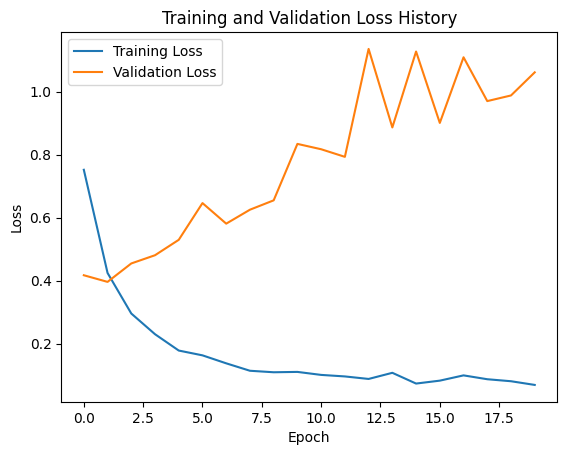

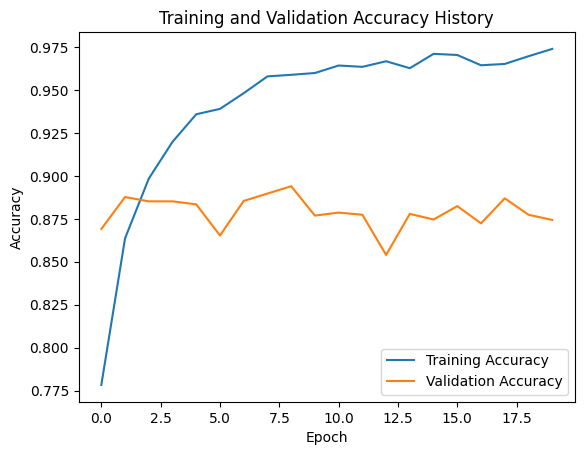

In [20]:
# Affichage de l'historique de perte
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Affichage de l'historique de précision
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [21]:
report = classification_report(Y_valid, Y_pred_classes, target_names=labels)
print(report)

              precision    recall  f1-score   support

   Butterfly       0.91      0.91      0.91       170
 Caterpillar       0.83      0.77      0.80        70
     Chicken       0.75      0.95      0.84       137
        Crab       0.81      0.91      0.86       114
        Deer       0.95      0.81      0.87       177
        Duck       0.53      0.59      0.56        88
       Eagle       0.94      0.93      0.93       178
        Fish       0.95      0.77      0.85       617
        Frog       0.87      0.81      0.84        77
     Giraffe       0.53      0.83      0.64        23
       Goose       0.32      0.55      0.40        33
       Horse       0.90      0.78      0.83       143
   Jellyfish       0.92      1.00      0.96        92
     Ladybug       0.67      0.94      0.79        35
        Lion       0.99      0.96      0.97       100
      Lizard       0.92      0.93      0.93       260
      Monkey       0.98      0.97      0.97       321
         Owl       0.93    

In [22]:
model.save('ResNet50_DEL.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
